In [9]:
import pickle

import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

import numpy as np; np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt

from plot_module import plot_ODE, plot_gillespie, plot_network, plot_neuron_graph, subset_layout
from sim_param_from_network import names_from_network, gillespie_param_from_network, dataframes_from_network, ODE_from_network
from network_generate import net_gen_line_chain, net_gen_line_ring, net_gen_line_powlawtree

In [2]:
nodetype_dict = {1:'soma', 2:'axon',3:'dendrite'}

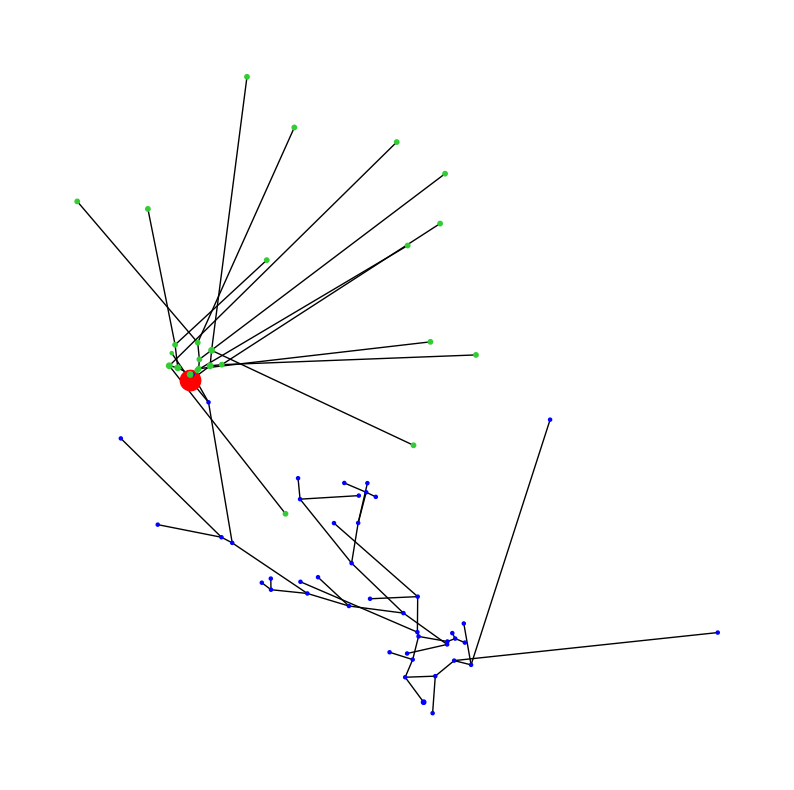

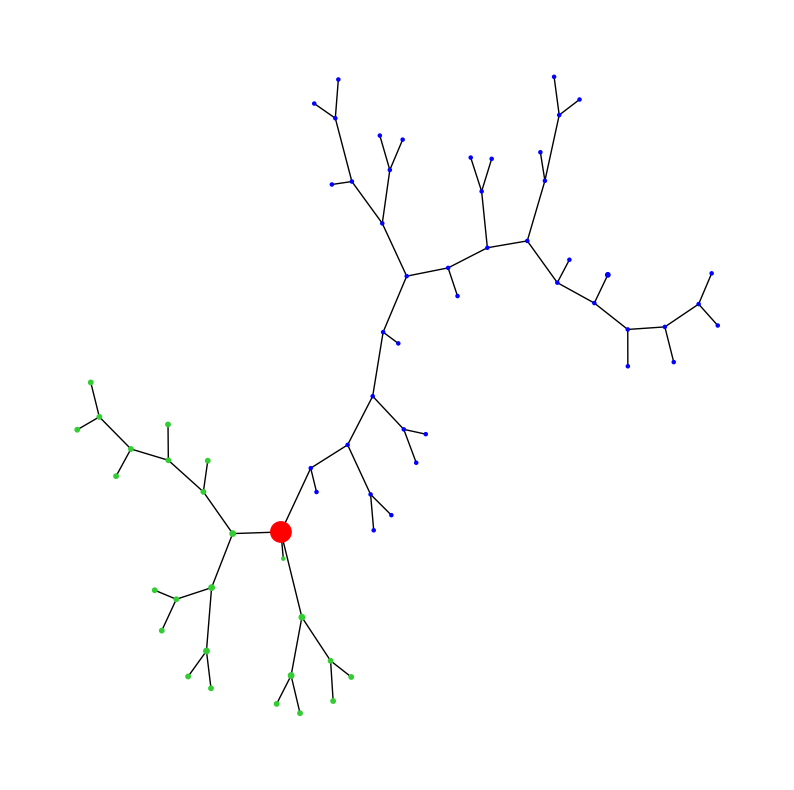

In [3]:
with open('neuron_shape_data/test_nx_neurgraph.pkl', 'rb') as f:
    G = pickle.load(f)    
plot_neuron_graph(G)

In [4]:
subgraph_roots = list(nx.descendants_at_distance(G, 1, 1))
subgraph_roots.sort(key=lambda x: x)
print(subgraph_roots)
# separate into subgraphs by removing all edges relating to the soma
G.remove_edges_from(list(G.edges(1)))

[8, 509, 512, 956]


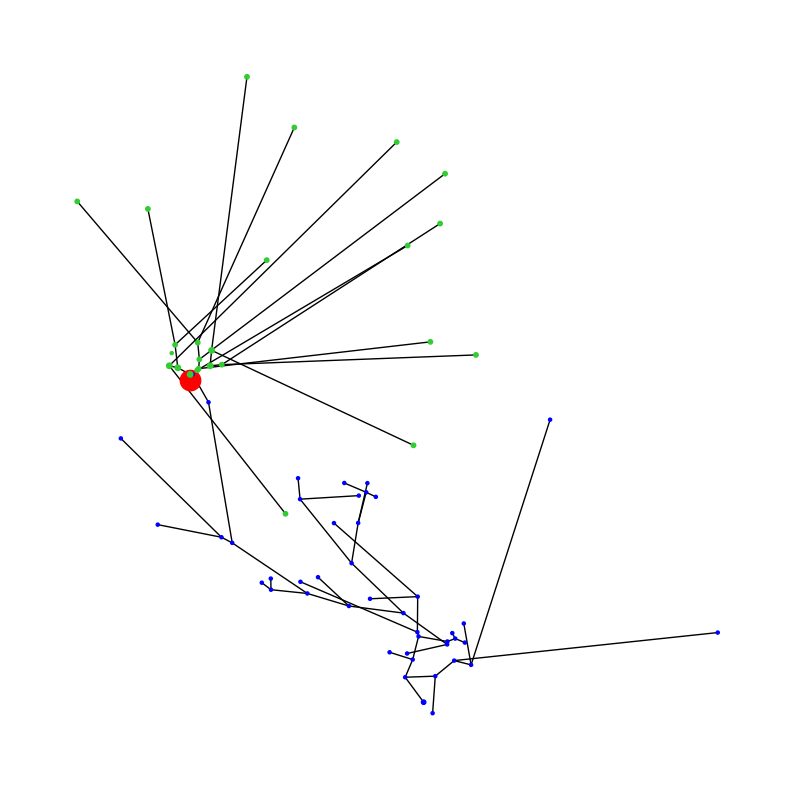

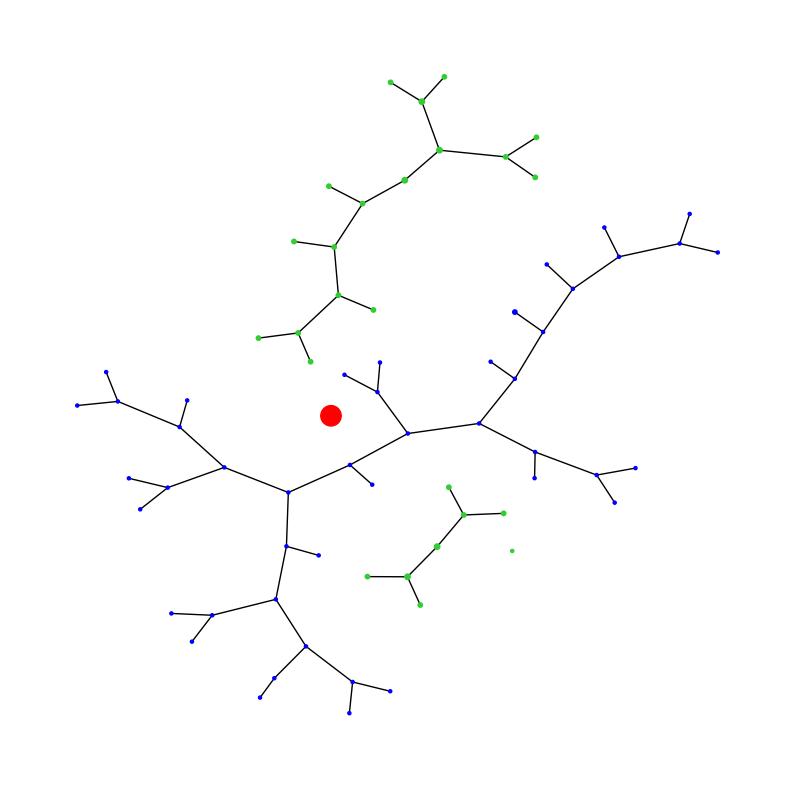

In [5]:
plot_neuron_graph(G)

In [38]:
subgraphs = list(nx.connected_components(G)); subgraphs = [list(subgraph) for subgraph in subgraphs]
subgraphs.sort(key=lambda x: x[0]); subgraphs = subgraphs[1:]
n_subgraphs = len(subgraphs)
subgraph_types = [nodetype_dict[G.nodes()[subgraph[0]]['nodetype']] for subgraph in subgraphs]

In [7]:
def make_tree_directed(G, subgraph_nodes, root):

    D = nx.DiGraph()

    # Add nodes and their attributes to the directed graph
    D.add_nodes_from((n, d) for n, d in G.nodes(data=True) if n in subgraph_nodes)

    # Add edges and their attributes to the directed graph using BFS
    for u, v, d in G.edges(data=True):
        if u in subgraph_nodes and v in subgraph_nodes:
            if nx.has_path(G, root, v):
                D.add_edge(u, v, **d)
            else:
                D.add_edge(v, u, **d)

    return D

In [33]:
# ladderize a directed graph
def ladderize(G):
    
    L = nx.DiGraph()

    for node, data in G.nodes(data=True):
        # For each node, add a forward and a reverse node to the ladder graph
        L.add_node(f"{node}F", **data)
        L.add_node(f"{node}R", **data)

    for u, v, data in G.edges(data=True):
        # For each edge, add an edge from the forward node of the source to the forward node of the target
        # and from the reverse node of the source to the reverse node of the target in the ladder graph
        L.add_edge(f"{u}F", f"{v}F", **data)
        L.add_edge(f"{v}R", f"{u}R", **data)

    for node in G.nodes():
        # For each node, add an edge between the forward and the reverse node in the ladder graph
        L.add_edge(f"{node}F", f"{node}R")
        L.add_edge(f"{node}R", f"{node}F")
    
    # Now, L is the ladder graph of G
    return L    
    
def circularize(G, root_node):
    # Function to get all root-to-leaf paths
    def get_paths(G, root_node):
        paths = []
        for leaf in (n for n, d in G.out_degree() if d==0):
            paths.extend(nx.all_simple_paths(G, root_node, leaf))
        return paths

    # Create an empty directed graph for the circular graph
    C = nx.DiGraph()

    # Get all root-to-leaf paths
    paths = get_paths(G, root_node)
    
    # If the graph has only one node, create a forward and a reverse node and connect them
    if len(G.nodes) == 1:
        node_data = G.nodes[root_node]
        C.add_node(f"{root_node}F", **node_data)
        C.add_node(f"{root_node}R", **node_data)
        C.add_edge(f"{root_node}F", f"{root_node}R")
    
    else:
        # For each path
        for path in paths:
            for i in range(len(path)-1):
                edge_data = G.edges[path[i], path[i+1]]
                node_data = G.nodes[path[i+1]]

                # Add forward and reverse strands
                C.add_edge(f"{path[i]}F", f"{path[i+1]}F", **edge_data)
                C.add_node(f"{path[i+1]}F", **node_data)

                C.add_edge(f"{path[i+1]}R", f"{path[i]}R", **edge_data)
                C.add_node(f"{path[i+1]}R", **node_data)

            # Connect forward and reverse strands at the leaf nodes
            C.add_edge(f"{path[-1]}F", f"{path[-1]}R")
            #C.add_edge(f"{path[-1]}R", f"{path[-1]}F")

    # Now, C is the circularized graph of G
    return C

def bidirectionalize(G):
    # Create an empty directed graph for the bidirectional graph
    B = nx.DiGraph()

    # Iterate over the nodes in the original graph
    for node, data in G.nodes(data=True):
        B.add_node(node, **data)

    # Iterate over the edges in the original graph
    for u, v, data in G.edges(data=True):
        # For each edge, add an edge and its reverse to the bidirectional graph
        B.add_edge(u, v, **data)
        B.add_edge(v, u, **data)

    # Now, B is the bidirectional graph of G
    return B

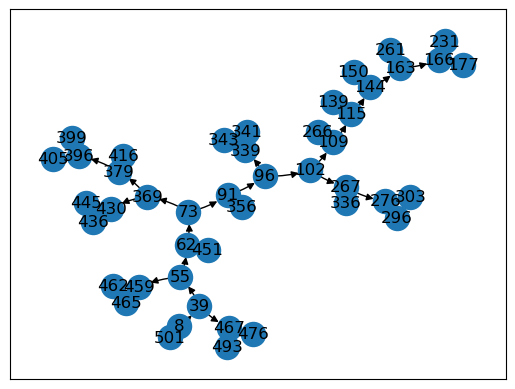

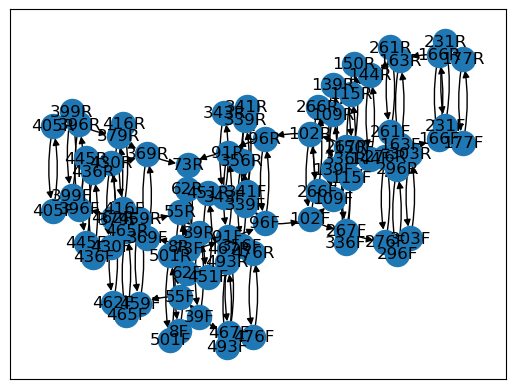

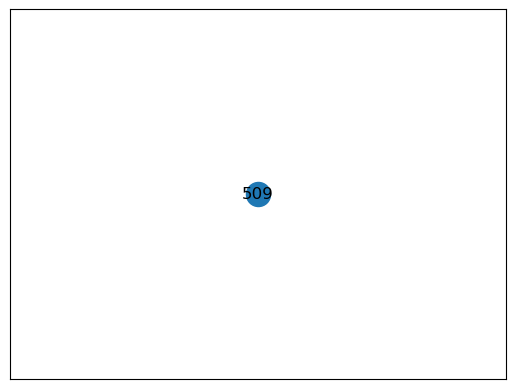

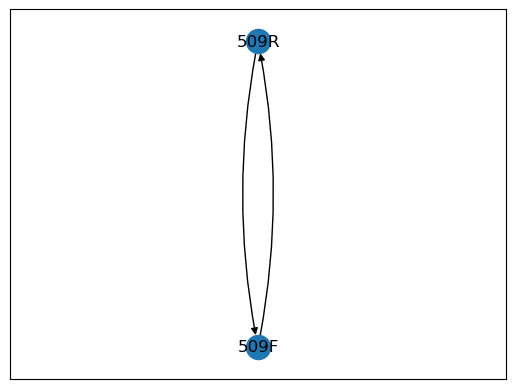

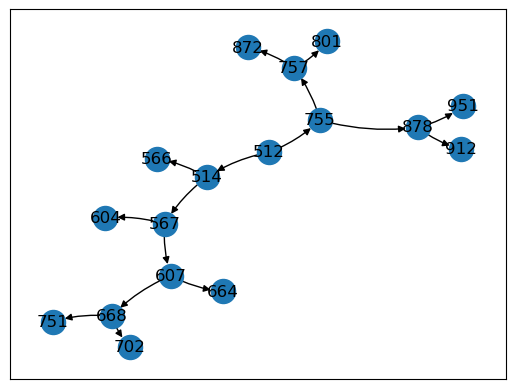

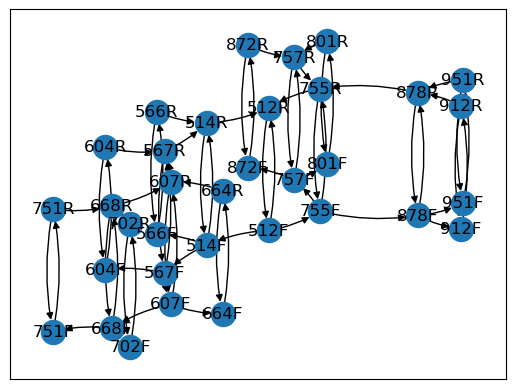

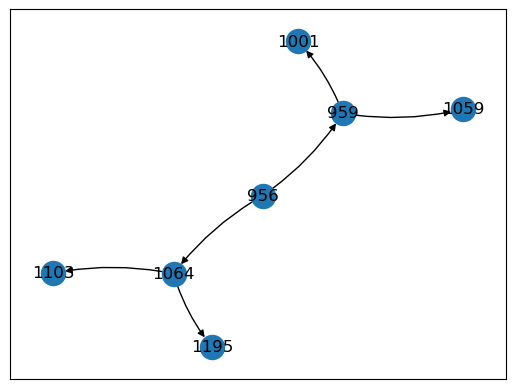

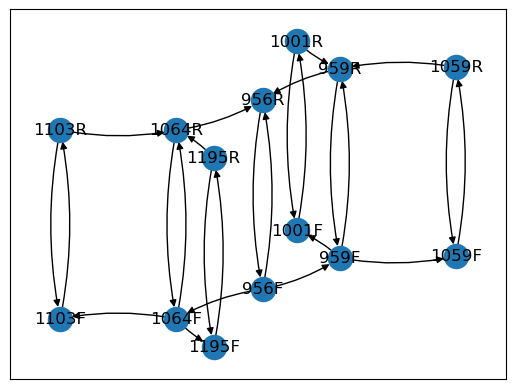

In [37]:
change = 'ladder'

for i in range(n_subgraphs):
    
    dir_graph = make_tree_directed(G, subgraphs[i], subgraph_roots[i])
    pos = subset_layout(dir_graph)
    
    nx.draw_networkx(dir_graph, pos = pos, connectionstyle='arc3,rad=0.1')
    plt.show()
    
    if   change == 'ladder':
        # ladderize graph
        out_graph = ladderize(dir_graph)
        # calculate new positions for visualizing
        newpos = {f'{key}F':pos[key] for key in pos}
        for key in pos: newpos[f'{key}R'] = (pos[key][0], pos[key][1]+2000)
    
    elif change == 'circle':
        # circularize graph
        out_graph = circularize(dir_graph, subgraph_roots[i])
        # calculate new positions for visualizing
        newpos = {f'{key}F':pos[key] for key in pos}
        for key in pos: newpos[f'{key}R'] = (pos[key][0], pos[key][1]+2000)
        
    elif change == 'bidirect':
        # circularize graph
        out_graph = bidirectionalize(dir_graph)
        # calculate new positions for visualizing
        newpos = pos    
    
    nx.draw_networkx(out_graph, pos = newpos, connectionstyle='arc3,rad=0.1')
    plt.show()